### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [1]:
# Select the API to use and load the benchmark program
api = "qiskit"
import hamlib_simulation_benchmark

# configure the QED-C Benchmark package for use with the given API
_, _ = hamlib_simulation_benchmark.qedc_benchmarks_init(api)

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 12
skip_qubits = 1
max_circuits = 1
num_shots = 1000

# Select the backend 
#backend_id = "qasm_simulator"
backend_id = "statevector_simulator"
provider_backend = None
exec_options = {}

#############

# place resulting data and images into a folder with "paper" suffix
import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 16

skip_execution = False


In [2]:
import numpy as np
import time
import os

# Configure module paths
import sys
sys.path.insert(1, "_common")
sys.path.insert(1, "qiskit")

sys.path.insert(1, "../_common/qiskit")
import execute

# Import HamLib helper functions (from _common)
import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
import hamlib_simulation_kernel

# Import Observable helper functions
import observables
import evolution_exact

# Plotting functions
#import metric_plots

verbose = True

#### for executing circuits to compute observables ...

# Import Qiskit and Qiskit Pauli operator classes
#from qiskit.quantum_info import Pauli, SparsePauliOp
#from qiskit import QuantumCircuit

# Initialize simulator backend
#from qiskit_aer import Aer
#backend = Aer.get_backend('qasm_simulator')

backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

import sys
sys.path.insert(1, "../")

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model
exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
from new_functions import metrics_object



### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[ 3 ]     # just do a single Hamiltonian in this notebook

###########

# list of observable computation methods to sweep
#group_method_list = [ None, "simple", "N", "estimator" ]
group_method_list = [ "simple", "N" ]

# limit testing to simple for now
# group_method = "simple"

group_method = "simple"

if group_method == "N":
    use_diag_method = True
    num_k = 4
else:
    use_diag_method = False
    num_k = 1

print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# this could be a loop ...

print("============================================================\n")
print(f"Testing expectation grouping method: {group_method}\n") 



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}


Testing expectation grouping method: simple



### Load the Given Hamiltonian to get its Pauli terms

In [4]:
# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


... dataset_name = bh_graph-1D-grid-nonpbc-qubitnodes_Lx-6_U-10_enc-gray_d-4
... number of terms in Hamiltonian = 179



---
## Custom Functions used in this Notebook

### Arrange Pauli Terms into Commuting Groups
We show this here for information about the Hamiltonian being processed.

In [5]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

# print(f"... Pauli Term Groups:")
# for group in pauli_term_groups:
#     print(group)
        


... Number of terms in Hamiltonian: 179
... Number of groups created: 10



### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [6]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit

def get_ansatz(num_qubits, params):
    ansatz = EfficientSU2(num_qubits).decompose()
    ansatz.barrier()

    params_dict = {p: params[i] for i, p in enumerate(ansatz.parameters)}

    # Use assign_parameters instead of bind_parameters
    ansatz = ansatz.assign_parameters(params_dict)
    
    return ansatz

# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)

# print(ansatz_circuit)


[ 0.307  1.352  0.646  0.282 -0.48   0.917 -0.392  2.462  2.913 -0.732
  1.833  0.182  0.428  2.674 -2.695 -2.594 -3.015  2.09   1.748  2.325
  3.007  1.88  -0.242  1.763 -2.398  0.879 -2.241  2.794  0.137 -0.536
 -1.479  1.723 -0.276  0.43  -3.024  0.739  0.704  0.735  2.788  1.142
 -0.883 -0.396  1.242 -2.763  1.048  1.072 -1.82  -2.332 -1.16  -0.856
  0.441 -0.386  3.069 -2.5   -1.829 -2.128  0.962 -1.55  -0.212 -1.606
 -2.143 -2.448  0.982 -2.273 -1.906 -0.825  2.017 -2.531  2.123 -2.538
  2.994 -0.197  2.996  0.659  1.503 -2.895 -1.365 -2.386 -1.281 -2.396
 -1.144 -0.539 -2.739  1.209  0.418 -1.474  0.146 -2.551  0.477  2.697
 -1.14   1.052 -2.313  1.359 -1.323 -1.991]


### Generate Random Initialization States
Here we generate initialization states using a bitstring containing 0s and 1s only.

In [7]:
import random

def generate_random_int_and_bitstring(num_qubits):
    """
    Generates a random bitstring representing an integer from 0 to N-1,
    given a number of qubits exponentiated where N is a power of 2.

    Args:
        num_qubits (int): number of qubits for which to generate random int state.

    Returns:
        str: A random bitstring representation of an integer in range [0, N-1].
    """

    N = 2 ** num_qubits
    
    if N <= 0 or (N & (N - 1)) != 0:
        raise ValueError("N must be a power of 2.")

    num_bits = N.bit_length() - 1  # Determine the number of bits needed
    random_number = random.randint(0, N - 1)  # Pick a random number in range [0, N-1]
    
    return random_number, format(random_number, f'0{num_bits}b')  # Convert to bitstring with leading zeros


### Custom Observable Estimation Function
This function wraps the four steps of the process into a single function.

In [8]:
from new_functions import create_measurement_circuts, do_execute, compute_energy
from new_functions import compute_exact_value

def estimate_expectation_value_top(num_qubits, sparse_pauli_terms, group_method, num_shots):

    ######### Group Commuting Terms

    # Arrange the Pauli terms into commuting groups based on group_method
    ts = time.time()
    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

    grouping_time = round(time.time()-ts, 3)
    metrics_object["grouping_time"] = grouping_time
    #print(f"\n... finished grouping of terms, total grouping time = {grouping_time} sec.\n")
    
    ######### Create Base Circuit
    
    # create Trotterized evolution circuit for HamLib Hamiltonian
    ts = time.time()
    qc, _ = hamlib_simulation_kernel.HamiltonianSimulation(
        num_qubits=num_qubits, 
        #ham_op=sparse_pauli_terms,
        K = 0, t = 0.0,
        init_state = init_state,
        append_measurements = False,
        method = 1, 
    )

    create_time = round(time.time()-ts, 3)
    metrics_object["create_base_time"] = create_time
    #print(f"\n... finished creating base circuit, total creation time = {create_time} sec.\n")

    #print(qc)

    ######### Append Measurement Circuits
    
    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list, use_diag_method, num_k)

    #for c in circuits:
    #    print(c)

    ######### Execution
    
    results = do_execute(backend_id, circuits, num_shots)

    ######### Compute Energy
    
    energy = compute_energy(num_qubits, results, pauli_term_groups)
    energy = np.real(energy)

    return energy


### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


In [9]:
# Number of iterations performed with random initialization
iterations = 50

print(f"... executing on num_qubits = {num_qubits}")

# create arrays to hold metrics
init_values = []
exact_energies = []
computed_energies = []
metrics_array = []
from new_functions import initialize_metrics_row

# For each iteration, generate random input, compute observable, and store data
for it in range(iterations):
    
    #reset the metrics object
    metrics_object = initialize_metrics_row()

    ######### Initialize
    """
    # Create a quantum ansatz circuit with the given parameters (update later to use Parameter)
    qc = get_ansatz(num_qubits, params)  
    #print(qc)
    """
    init_value, init_state = generate_random_int_and_bitstring(num_qubits)
    init_values.append(init_value)

    ######### Compute Exact Energy
    
    exact_energy = compute_exact_value(num_qubits, init_state, sparse_pauli_terms)
    exact_energies.append(exact_energy)

    ######### Estimate Energy using Quantum Algorithm
    
    # estimate expectation using the benchmark functions
    energy = estimate_expectation_value_top(num_qubits, sparse_pauli_terms, group_method, num_shots)   
    computed_energies.append(energy)

    # Append metrics from this iteration to the array of metrics
    metrics_array.append(metrics_object)


... executing on num_qubits = 12


---
## Observalable Estimation Loop for Analysis
Here we compute an observable (energy) for the given Hamiltonian, sweeping over the specified set of group methods.  Using the value and timing analysis plots, this provides a means to compare the behavior of these methods.

### Generate Value Analysis Plots

Here, we plot the metrics obtained during the execution over the random initial states, while varying the observable computation method (group method). The absolute error values are plotted, along with an analysis of the distributions of errors.


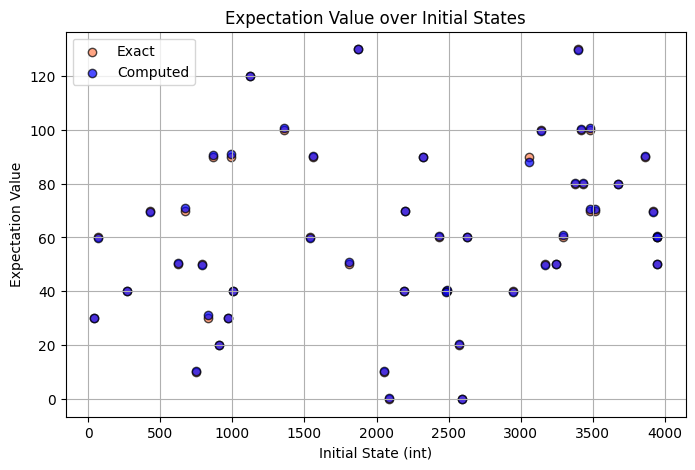

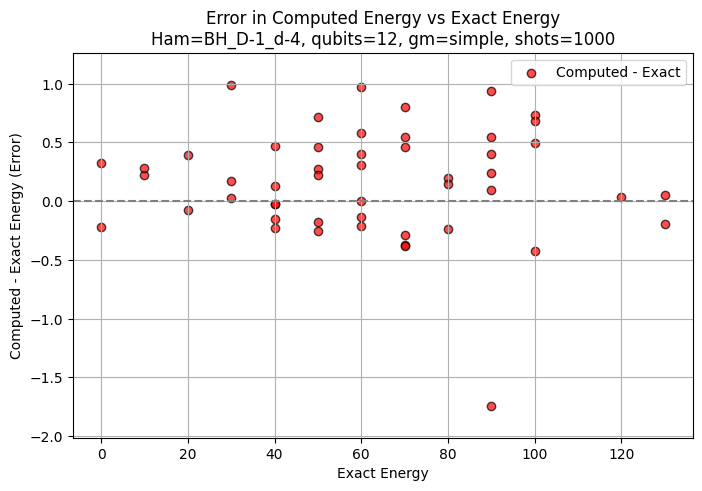

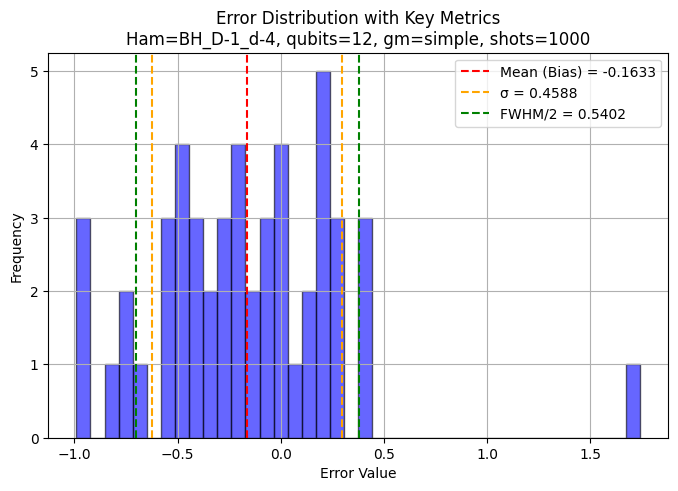


🔹 **Bias Detection**
Mean Error (Bias) = -0.1633
✅ No significant bias detected.


In [10]:
from metric_plots import plot_value_analysis_data

# Generate the value anlysis plots
plot_value_analysis_data(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method,
        num_shots,
        init_values, 
        exact_energies,
        computed_energies
    )

### Generate Timing Analysis Plot
Print the key timing metrics, without execution time, over a range of problems.

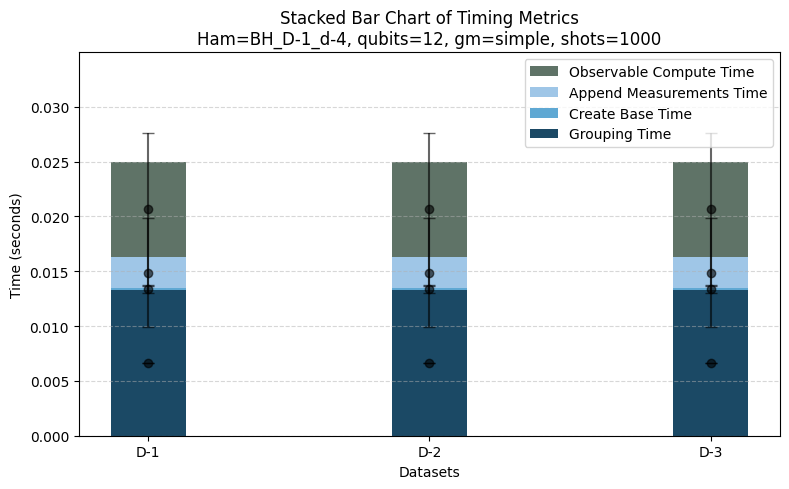

In [11]:

from new_functions import compute_timing_stats
from metric_plots import plot_timing_analysis_bar_chart

# Compute statistics for the collected metrics
stats_result = compute_timing_stats(metrics_array)
# print("")
# print(stats_result)

# Mimicking multiple datasets, until we implement the loop above
datasets = [
    stats_result,
    stats_result,
    stats_result
]

#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

dataset_labels = [
    {"name": "Dataset 1", "label": "D-1"},
    {"name": "Dataset 2", "label": "D-2"},
    {"name": "Dataset 3", "label": "D-3"},
]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method,
        num_shots,
        datasets,
        dataset_labels,
        categories,
        error_bar_position = "middle"
    )

# Version 2: Error bars at the top of the bars
#plot_timing_analysis_bar_chart(datasets, dataset_labels, error_bar_position="top")
